Import statements

In [34]:
import os
import torch
import torchvision
from torch import nn 
from torch.autograd import Variable
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset
import pyDOE2
from torch.autograd.functional import jacobian, hessian


Variables

In [35]:
x_bounds = [-1, 1]
t_bounds = [0, 1]
num_data_points = 2000
num_collocation_points = 4000
proportion_t_0 = 0.4 #the proportion of the data points which will exist at various points x along the boundary t = 0. The rest will be split between the boundaries x = -1 and x = 1 for all t

Generating Data

In [46]:
num_points_t_0 = (int) (num_data_points * proportion_t_0)
num_points_x_1 = (num_data_points - num_points_t_0)//2 # // is integer division
num_points_x_neg_1 = num_data_points - num_points_t_0 - num_points_x_1

#create num_data_points random data points on the boundaries of the PDE
t_0_points = np.array( list( zip(np.zeros(num_points_t_0), 2 * np.random.rand(num_points_t_0) - 1 ) ) )
x_1_points = np.array( list( zip(np.random.rand(num_points_x_1), np.full(num_points_x_1, 1)) ) ) #np.full() takes paramters shape, value. Shape can be a tuple for multidimensional arrays filled with value.
x_neg_1_points = np.array( list( zip(np.random.rand(num_points_x_neg_1), np.full(num_points_x_neg_1, -1)) ) )
x_points = np.concatenate(( x_1_points, x_neg_1_points ))

#Generating labels with the data
dtype = [('points', float, 2), ('label', float)] #need custom dtype because otherwise numpy doesn't like these combined arrays

t_0_labels = -np.sin(np.pi * t_0_points[:,1] )
t_0_combined = np.array(list( zip(t_0_points, t_0_labels) ), dtype=dtype)

x_labels = np.zeros(num_points_x_1 + num_points_x_neg_1)
x_combined = np.array(list( zip(x_points, x_labels) ), dtype=dtype)

combined_labels_data = np.concatenate( (t_0_combined, x_combined) )

np.random.shuffle(combined_labels_data)

data_points, labels = map(np.array, map(list, zip(*combined_labels_data)) )


Data Validation Code (Entirely ChatGPT Generated)

In [47]:
'''# Test 1: Ensure all data points lie on the correct boundaries
def test_boundaries(data_points):
    t_values = data_points[:, 0]
    x_values = data_points[:, 1]
    assert np.all((t_values == 0) | (x_values == 1) | (x_values == -1)), "Some points do not lie on the correct boundaries."

test_boundaries(data_points)
print("Test 1 passed!")

# Test 2: For t=0, label should be -sin(pi * x)
def test_labels_t_0(data_points, labels):
    mask_t_0 = data_points[:, 0] == 0
    expected_labels = -np.sin(np.pi * data_points[mask_t_0, 1])
    assert np.allclose(labels[mask_t_0], expected_labels), "Labels for t=0 do not match -sin(pi * x)."

test_labels_t_0(data_points, labels)
print("Test 2 passed!")

# Test 3: For x=-1 or x=1, label should be 0
def test_labels_x_boundaries(data_points, labels):
    mask_x_boundaries = (data_points[:, 1] == 1) | (data_points[:, 1] == -1)
    assert np.all(labels[mask_x_boundaries] == 0), "Labels for x=-1 or x=1 are not zero."

test_labels_x_boundaries(data_points, labels)
print("Test 3 passed!")
'''

Test 1 passed!
Test 2 passed!
Test 3 passed!


Preparing the Dataset and Dataloader

In [37]:
class PINN_DataSet(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

trainset = PINN_DataSet(data_points.astype(np.float32), labels.astype(np.float32)) #convert to float32, or else later the resulting torch tensors will be of torch.float64 type, which is not compatible with the neural network

batch_size = num_data_points #no mini-batches

num_workers = 0

trainloader = DataLoader(
    trainset,
    batch_size = batch_size,
    shuffle = True,
    num_workers = num_workers
)



Collocation Points

In [38]:
def lhs_samples(n): #generate n collocation points via Latin Hypercube Sampling. Each point is a (t,x)
    lhs_array = pyDOE2.lhs(2, samples=n) #Two dimensions. Values from 0 to 1
    lhs_array[:,1] = 2*lhs_array[:,1] - 1 #convert range of x values to -1 to 1
    return lhs_array

collocation_points = lhs_samples(num_collocation_points)

Defining the Neural Network

In [39]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential( #9 layers of 20 neurons each
            nn.Linear(2,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,20),
            nn.Tanh(),
            nn.Linear(20,1),
            #nn.Tanh()

        )

    def forward(self, x):
        return self.net(x)



Loss Function

In [40]:
def MSE_f(collocation_points, neural_network, device):

    collocation_points = collocation_points.astype(np.float32)

    sum = torch.zeros(1, requires_grad=True).to(device)

    for i in range(num_collocation_points):

        collocation_input = torch.tensor(collocation_points[i] , requires_grad=True).to(device)
        u = neural_network(collocation_input)
        u_derivs, = torch.autograd.grad(u, collocation_input, retain_graph=True, create_graph=True)
        u_t = u_derivs[0]
        u_x = u_derivs[1]
        u_second_derivs, = torch.autograd.grad(u_x, collocation_input, retain_graph=True, create_graph=True)
        u_xx = u_second_derivs[1]
        sum = sum + (u_t + u*u_x - (0.01/torch.pi)*u_xx)**2


    return (sum/num_collocation_points).squeeze() #get rid of unnecessary dimension: [N, 1] to [N]


    

def criterion(output, label, collocation_points, neural_network, device): #collocation_points must be a NUMPY ARRAY
    mse_u = nn.MSELoss()(output, label)
    mse_f = MSE_f(collocation_points, neural_network, device)
    return mse_u + mse_f, mse_u.item(), mse_f.item()
    #return 100*(mse_u + 1000000*mse_f), mse_u.item(), mse_f.item()

Model Training

In [41]:
pinn = PINN()
optimizer = torch.optim.Adam(pinn.parameters(), lr=0.01)

num_epochs = 20 #I have no idea how many epochs were used in the paper's implementation. Let's just do a lot for now and see how quickly training converges

#use the GPU to train if possible, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: " + ("GPU" if torch.cuda.is_available() else "CPU"))
pinn.to(device)

try:
    for epoch in range(num_epochs):

        print(f"EPOCH {epoch + 1} out of {num_epochs}")
        train_running_loss = 0


        for data in trainloader:

            input, label = data #input and label already seem to be tensors. Tbh, I am a little confused when this happened. I don't think I ever explicitly turned them into tensors. They used to both be numpy arrays. EDIT: Further research seems to show that dataloader does this automatically as it fetches data from the dataset
            input = input.to(device)
            label = label.to(device)


            def closure():

                optimizer.zero_grad() #reset the gradient so that the previous iteration does not affect the current one
                output = pinn(input) #run the batch through the current model
                loss, mse_u, mse_f = criterion(output, label, collocation_points, pinn, device) #calculate the loss
                loss.backward() #Using backpropagation, calculate the gradients
                print(f"Avg MSE Loss Per Boundary Data Point: {mse_u}")
                print(f"Avg f(t,x)^2 Per Collocation Point: {mse_f}")
                return loss

            optimizer.step(closure) #Using the gradients, adjust the parameters    

except KeyboardInterrupt:
    print("Training interrupted by user.")  

print("TRAINING COMPLETE!")  

Using device: CPU
EPOCH 1 out of 20
Avg MSE Loss Per Boundary Data Point: 0.2094442993402481
Avg f(t,x)^2 Per Collocation Point: 2.0370960385207582e-07
EPOCH 2 out of 20
Avg MSE Loss Per Boundary Data Point: 0.22833456099033356
Avg f(t,x)^2 Per Collocation Point: 1.1253317097725812e-05
EPOCH 3 out of 20
Avg MSE Loss Per Boundary Data Point: 0.20612281560897827
Avg f(t,x)^2 Per Collocation Point: 1.3727086297876667e-05
EPOCH 4 out of 20
Avg MSE Loss Per Boundary Data Point: 0.20477740466594696
Avg f(t,x)^2 Per Collocation Point: 3.9797290810383856e-05
EPOCH 5 out of 20
Avg MSE Loss Per Boundary Data Point: 0.2089090645313263
Avg f(t,x)^2 Per Collocation Point: 1.8827118765329942e-05
EPOCH 6 out of 20
Avg MSE Loss Per Boundary Data Point: 0.20802517235279083
Avg f(t,x)^2 Per Collocation Point: 1.2821645896110567e-06
EPOCH 7 out of 20
Training interrupted by user.
TRAINING COMPLETE!


Saving the Code

In [ ]:
base_path = "./"
base_name = "pinn_model"
extension = ".pth"

counter = 0
model_save_path = os.path.join(base_path, base_name + extension)

while os.path.exists(model_save_path):
    counter += 1
    model_save_path = os.path.join(base_path, f"{base_name}_{counter}{extension}")

torch.save(pinn.state_dict(), model_save_path)

print("Model saved!")

Model saved!


Visual Plot (Written Entirely via ChatGPT. For now)

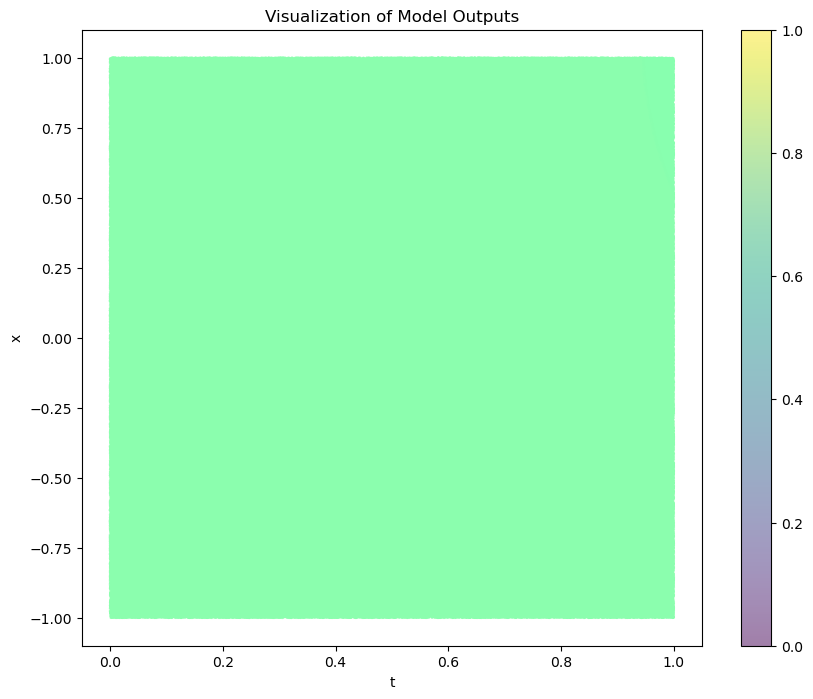

In [ ]:
# 1. Generate Random Points
num_points = 1000000
t_values = np.random.rand(num_points)
x_values = np.random.uniform(-1, 1, num_points)
points = np.vstack((t_values, x_values)).T
points_tensor = torch.tensor(points, dtype=torch.float32).to(device)

# 2. Feed the Points through the Model
with torch.no_grad():
    model_outputs = pinn(points_tensor).cpu().numpy()

# Normalize the model outputs to be between 0 and 1 for color mapping
normalized_outputs = (model_outputs - (-1)) / (1 - (-1))

# 3. Color Mapping
colors = plt.cm.rainbow(normalized_outputs.squeeze())

# 4. Plotting
plt.figure(figsize=(10, 8))
plt.scatter(t_values, x_values, c=colors, s=1, alpha=0.5)
plt.xlabel("t")
plt.ylabel("x")
plt.colorbar()
plt.title("Visualization of Model Outputs")
plt.show()